### Importing Dependencies

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import keras

2024-07-14 02:48:19.324908: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-07-14 02:48:19.332100: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:479] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-14 02:48:19.342560: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:10575] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-14 02:48:19.342580: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1442] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-07-14 02:48:19.349405: I tensorflow/core/platform/cpu_feature_gua

In [2]:
import pickle

def load_set(directory):
    try:
        with open(f"{directory}/texts.pkl", "rb") as fp:
            processed_texts = pickle.load(fp)
        
        with open(f"{directory}/labels.pkl", "rb") as fp:
            labels = pickle.load(fp)
    
    except:
        print(f'{directory} files not found. Please run the preprocess.ipynb before!')
    
    return processed_texts, labels

In [3]:
processed_texts, labels = load_set('train')
processed_val_texts, val_labels = load_set('val')
processed_test_texts, test_labels = load_set('test')

In [4]:
processed_texts[:5]

['vent life take turn go discord Dran#1230 dran#1230 discord get chest rn',
 'm go need delete lot meme soon valentine day crush ask',
 'look recent portal result hpv mean rechecke portal result pap smear confirm recent normal smear initial abnormal smear Z01.42 mean hpv dormant threat need biopsy find hard believe go lsik/ hsil normal bc m eat healthy work 40 hrs m stress plus time go check go biopsy Dr see biopsy not process june find odd abnormal normal 2 month know 3rd opinion',
 'crisis support load hour talk lifeline hour byond blue repeat say feel bloody bad swear get support chat bot rock',
 'new gunpla interest mind order build amazon like week ago m box look like complex ill probably go to grab tomorrow everyday lot learn']

In [5]:
lengths = [len(processed_text) for processed_text in processed_texts if len(processed_text) < 2000]

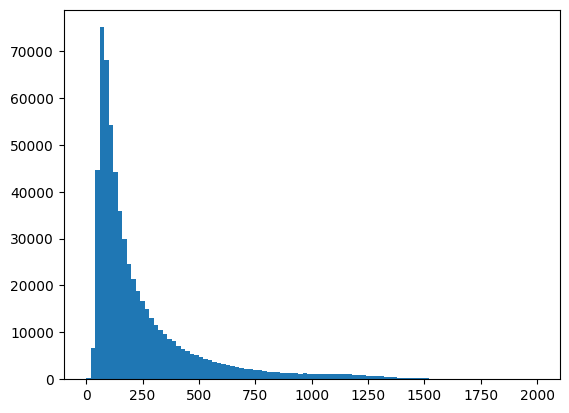

In [6]:
plt.hist(lengths, bins=100)
plt.show()

### Creating the Model

#### Vectorization

In [7]:
TextVectorization = keras.layers.TextVectorization

vectorize_layer = TextVectorization(
    max_tokens=3000,
    output_mode='int',
    output_sequence_length=200,
)

vectorize_layer.adapt(processed_texts + processed_val_texts)

2024-07-14 02:48:21.376664: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 02:48:21.397173: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-07-14 02:48:21.399699: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [8]:
vectorized_texts = vectorize_layer(processed_texts)

In [9]:
vectorized_val_texts = vectorize_layer(processed_val_texts)

#### Creating the model

In [10]:
Sequential = keras.models.Sequential

model = Sequential([
    keras.layers.Embedding(3001, 16),
    keras.layers.Bidirectional(keras.layers.LSTM(20, return_sequences=True)),
    keras.layers.Bidirectional(keras.layers.LSTM(20)),
    keras.layers.Dense(1, activation='sigmoid')
])

model.compile(
    loss='binary_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

In [11]:
h = model.fit(
    vectorized_texts, labels,
    validation_data=(vectorized_val_texts, val_labels),
    epochs=20,
    callbacks=[
        keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
    ]
)

Epoch 1/20


2024-07-14 02:48:30.696501: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:465] Loaded cuDNN version 8902


19532/19532 ━━━━━━━━━━━━━━━━━━━━ 444s 23ms/step - accuracy: 0.8127 - loss: 0.4081 - val_accuracy: 0.8292 - val_loss: 0.3760
Epoch 2/20
  232/19532 ━━━━━━━━━━━━━━━━━━━━ 7:14 22ms/step - accuracy: 0.8286 - loss: 0.3683

KeyboardInterrupt: 

### Evaluating the Model

In [12]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 200, 16)        │        48,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 200, 40)        │         5,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 40)             │         9,760 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │            41 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 191,213 (746.93 KB)

 Trainable params: 63,737 (248.97 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 127,476 (497.96 KB)

In [13]:
vectorized_test_texts = vectorize_layer(processed_test_texts)

In [14]:
_ = model.evaluate(vectorized_test_texts, test_labels)

2198/2198 ━━━━━━━━━━━━━━━━━━━━ 24s 11ms/step - accuracy: 0.8293 - loss: 0.3728


In [15]:
y_pred = model.predict(vectorized_test_texts)
y_pred = (y_pred > 0.5).astype(int)

y_pred = np.array(list(map(lambda x: x[0], y_pred)))

2198/2198 ━━━━━━━━━━━━━━━━━━━━ 18s 8ms/step


In [16]:
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test_labels, y_pred).ravel()

fpr = fp / (fp + tn)
print(f"False Positive Rate: {fpr:.4f}")

fnr = fn / (fn + tp)
print(f"False Negative Rate: {fnr:.4f}")

False Positive Rate: 0.1081
False Negative Rate: 0.3060


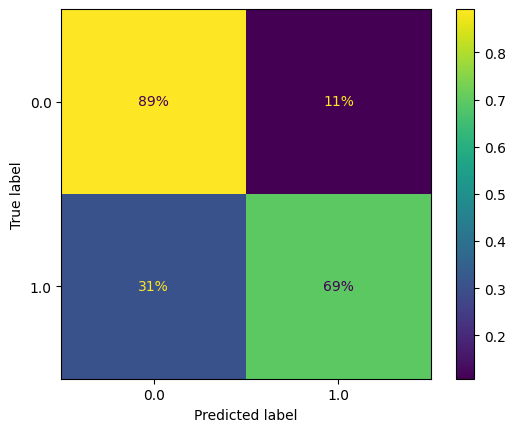

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay

ConfusionMatrixDisplay.from_predictions(test_labels, y_pred, normalize="true",
                                        values_format=".0%")
plt.show()